Description

This file trains the XGBoost models and creates the reconstructions. 

New to this code, test years are separated from training and evaluation years according to Gregor et al. (2019)

Both are saved to directories and can be found on this project's figshare page.

Inputs

In [1]:
# =========================================
# For accessing directories
# =========================================
#root_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/dpco2/no_atm_seasonality/climate_indices"
#root_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/dpco2/no_atm_seasonality/fewer_vars"
#root_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/dpco2/no_atm_seasonality/smooth_all_features"
#root_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/dpco2/no_atm_seasonality/mon_sampling"
root_dir = "/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC_Taka"

reference_output_dir = f"{root_dir}/references"
#data_output_dir = f"/data/artemis/workspace/vbennington/SOCAT_ML/pCO2_DIC/data/processed"
data_output_dir = f"{root_dir}/data/processed"
model_output_dir = f"{root_dir}/models/trained"
recon_output_dir = f"{root_dir}/models/reconstructions"
other_output_dir = f"{root_dir}/models/performance_metrics"

approach = 'xg'
approach_output_dir = f"{other_output_dir}/{approach}"
# =========================================
# Number of cores you have access to for model training
# =========================================
jobs = 30

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import numpy.ma as ma
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
%config InlineBackend.print_figure_kwargs = {'dpi':300, 'bbox_inches': 'tight'}
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
import scipy
import sklearn.linear_model 
import pickle

Modules

In [4]:
# standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
import xarray as xr
import pandas as pd
import joblib
import pickle

# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
import sklearn.model_selection as mselect

# Python file with supporting functions
import pre_SOCAT

Predefined Values

In [10]:
# Loading references

In [5]:
# =========================================
# Defining some inputs for the modeling process
# =========================================

# Train-validate-test split proportions for LET runs:
#val_prop = .2
#test_prop = .2

# Parameter grids
xg_param_grid = {"n_estimators":[1000, 2000, 3000],
                 "max_depth":[4,5,6,7,8,9]
                }


# Feature and target lists for feeding into ML
#features_sel = ['sst', 'sss', 'mld_log', 'chl_log', 'xco2', 'enso', 'nao', 'soi', 'A', 'B', 'C', 'T0', 'T1']  # Climate Indices

#features_sel = ['sst', 'sss', 'mld_log', 'chl_log', 'xco2', 'A', 'B', 'C', 'T0', 'T1']  # Fewer Vars

#features_sel = ['sst', 'sss', 'mld_log', 'chl_log', 'xco2', 'enso', 'A', 'B', 'C', 'T0', 'T1']  # ENSO

#features_sel = ['sst', 'sss', 'mld_log', 'chl_log', 'xco2', 'enso','enso_sst','nao','nao_sst','sam','sam_sst','A', 'B', 'C', 'T0', 'T1']  # Climate Indices

#features_sel = ['sst_anom', 'sss_anom', 'mld_log', 'chl_anom', 'xco2', 'enso','enso_sst','nao','nao_sst','sam','sam_sst','A', 'B', 'C', 'T0', 'T1']  # Smooth Climate Indices w sst

#features_sel = ['sst_anom', 'sss_anom', 'mld_log', 'chl_anom', 'xco2', 'enso','enso_sst','nao','nao_sst','sam','sam_sst','A', 'B', 'C', 'T0', 'T1']  # 

#features_sel = ['sst','sst_anom','sss','sss_anom','chl_log','chl_anom','mld_log','xco2','enso','enso_sst','nao','nao_sst','sam','sam_sst','A','B','C','T0','T1'] # Everything

#features_sel = ['sst','sst_anom','sss','sss_anom','chl_log','chl_anom','mld_log','xco2','enso','nao','sam','A','B','C','T0','T1'] # pCO2_nonT

features_sel = ['sst','sst_anom','sss','sss_anom','chl_log','chl_anom','mld_log','xco2','A','B','C','T0','T1'] # pCO2_DIC

#features_sel = ['sst','sst_anom','sss','sss_anom','chl_log','chl_anom','mld_log','xco2','enso','sam','nao','A','B','C','T0','T1'] # pCO2_DIC_indices

#target_sel = ['dpco2']
target_sel = ['pCO2_DIC']  # What we reconstruct with ML
final_sel = ['pCO2'] # What we want RMSE, etc. for (pCO2 = pCO2_DIC + pCO2_T)


In [8]:
# Want to train with 4 out of every 5 months, and test on the fifth month
date_range_start = '1982-01-01T00:00:00.000000000'
date_range_end = '2019-12-01T00:00:00.000000000'

# create date vector
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS') + np.timedelta64(14, 'D')
select_dates = []
test_dates = []
for i in range(0,len(dates)):
    if i % 5 != 0:
        select_dates.append(dates[i])
    if i % 5 == 0:
        test_dates.append(dates[i])
year_mon = []
for i in range(0,len(select_dates)):
    tmp = select_dates[i]
    year_mon.append(f"{tmp.year}-{tmp.month}")
test_year_mon = []
for i in range(0,len(test_dates)):
    tmp = test_dates[i]
    test_year_mon.append(f"{tmp.year}-{tmp.month}")

In [7]:
approach = 'xg'
approach_output_dir = f"{other_output_dir}/{approach}"

#random_seeds = [57, 16]   - Climate Indices
#random_seeds = [12, 89]  # fewer Vars run
#random_seeds = [71, 28] # ENSO run
#random_seeds = [36,95] # Sampling 4 out of 5 months
#random_seeds = [82, 49] # ENSO monthly sampling
#random_seeds = [40, 9] # Indices monthly sampling
#random_seeds = [13, 30] # ENSO-SST monthly sampling
#random_seeds = [27, 42] # Smooth Climate Indices
#random_seeds = [61, 57] # Smooth All Features
#random_seeds = [50, 68] # pCO2_nonT
#random_seeds = [1,71] # pCO2_DIC
#random_seeds = [39,76] # pCO2_DIC_Products
#random_seeds = [99,15] # pCO2_DIC_indices
random_seeds = [72,47] #pCO2_DIC_Taka

first_run = True

In [9]:
if first_run:
    best_params = {} # Uncomment if running cross validation to find best params
else:
    #gregor_dir = f"/data/artemis/workspace/vbennington/SOCAT_ML/dpco2/no_atm_seasonality/fewer_vars/models/reconstructions/xg/Gregor1"
    param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
    with open(param_fname, 'rb') as handle:
        best_params = pickle.load(handle)
    
test_performance = defaultdict(dict)

K_folds = 3
approach = "xg"

print(datetime.datetime.now())

# Data file path
data_dir = f"{data_output_dir}"
fname = f"data_clean_2D_mon_1x1_198201-201912.pkl"
file_path = f"{data_dir}/{fname}"
        
# Read in data, create some selection filters, produce a reduced dataframe
df = pd.read_pickle(file_path)

# Get rid of features we never use:
df = df.drop(columns=['chl','mld'])

# Test on every fifth month to reduce autocorrelation along cruise tracks, but still sample many climate anomalies...
df['year'] = df.index.get_level_values('time').year
df['mon'] = df.index.get_level_values('time').month
df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
#df['enso_sst'] = df['enso'] * df['sst_anom']
#df['nao_sst'] = df['nao'] * df['sst_anom']
#df['sam_sst'] = df['sam'] * df['sst_anom']

# Get rid of N    
recon_sel = (~df[features_sel+['net_mask']].isna().any(axis=1))   # Dont' have dpCO2 for non-SOCAT locations, but have features

# Try (200,-250) as cut off based on histogram plots of SOCAT data:
################################################################################################################################        
sel = (recon_sel & (df['socat_mask'] == 1)) & ((df[target_sel] < 850)).to_numpy().ravel()           # locations not masked AND IN SOCAT SAMPLING and within reason

print("SOCAT length =",sum(sel))

################################################################################################################################
# Randomly select years for training, hyperparameterization (validation), and testing
################################################################################################################################
#random.seed()
#years = [1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]

# Shuffle years
#random.shuffle(years)
#train_years = years[0:23]
#val_years = years[23:31]
#test_years = years[31:39]

# Gregor Years
#test_years = [1984, 1990, 1995, 2000, 2005, 2010, 2014, 2018]
#train_val_years = [1982, 1983, 1985, 1986, 1987, 1988, 1989, 1991, 1992, 1993, 1994, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2015, 2016, 2017, 2019]

# Run 2
#test_years = [1985, 1991, 1996, 2001, 2006, 2011, 2015, 2019]
#train_val_years = [1982, 1983, 1984, 1986, 1987, 1988, 1989, 1990, 1992, 1993, 1994, 1995, 1997, 1998, 1999, 2000, 2002, 2003, 2004, 2005, 2007, 2008, 2009, 2010, 2012, 2013, 2014, 2016, 2017, 2018]

# Run 3
#test_years = [1982, 1986, 1992, 1997, 2002, 2007, 2012, 2016]
#train_val_years = [1983, 1984, 1985, 1987, 1988, 1989, 1990, 1991, 1993, 1994, 1995, 1996, 1998, 1999, 2000, 2001, 2003, 2004, 2005, 2006, 2008, 2009, 2010, 2011, 2013, 2014, 2015, 2017, 2018, 2019]

# Run 4
#test_years = [1983, 1987, 1993, 1998, 2003, 2008, 2013, 2017]
#train_val_years = [1982, 1984, 1985, 1986, 1988, 1989, 1990, 1991, 1992, 1994, 1995, 1996, 1997, 1999, 2000, 2001, 2002, 2004, 2005, 2006, 2007, 2009, 2010, 2011, 2012, 2014, 2015, 2016, 2018, 2019]

# Run 5
#test_years = [1988, 1989, 1994, 1999, 2004, 2009, 2014, 2019]
#train_val_years = [1982, 1983, 1984, 1985, 1986, 1987, 1990, 1991, 1992, 1993, 1995, 1996, 1997, 1998, 2000, 2001, 2002, 2003, 2005, 2006, 2007, 2008, 2010, 2011, 2012, 2013, 2015, 2016, 2017, 2018]

#print("test = ",test_years)
#print("train/val =",train_val_years)

#print("Train = ",np.sort(train_years))
#print("Val = ",np.sort(val_years))
#print("Test = ",np.sort(test_years))
###################################################################################################################################
# Separate the data sets
###################################################################################################################################

#train_val_sel = (sel & pd.Series(sel.index.get_level_values('time').year, index=sel.index).isin(train_val_years))                       # Need to train where there is SOCAT data and during a non-test year
train_val_sel = ((sel) & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
print("Train/Val length = ",sum(train_val_sel))

#test_sel = (sel & pd.Series(sel.index.get_level_values('time').year, index=sel.index).isin(test_years)) 
test_sel = ((sel) & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()   # Should be along SOCAT track
print("Test length =",sum(test_sel))     

#val_sel = (sel & pd.Series(sel.index.get_level_values('time').year, index=sel.index).isin(val_years))                         # Should be along SOCAT track
#print("Validation length =",sum(val_sel))     
    
#nonsocat_sel = (recon_sel & (df['socat_mask'] == 0))      # locations not masked and NOT IN SOCAT SAMPLING
#print("NON-SOCAT length =",sum(nonsocat_sel))

################################################################################################################################
        
# Convert dataframe to numpy arrays, train/val/test split
X = df.loc[sel,features_sel].to_numpy()         
y = df.loc[sel,target_sel].to_numpy().ravel()

# Where no SOCAT data ONLY ###########
#X_nonsocat = df.loc[nonsocat_sel,features_sel].to_numpy()

# Where SOCAT data ONLY #######################
#X_socat = df.loc[sel,features_sel].to_numpy()

# Where we want dpCO2 reconstructed
X_recon = df.loc[recon_sel,features_sel].to_numpy()         


#X_train, X_val, y_train, y_val = mselect.train_test_split(X_train_val, y_train_val, test_size=val_prop, random_state=42)  
# Convert dataframe to numpy arrays, train/val/test split
X_train_val = df.loc[train_val_sel,features_sel].to_numpy()                # create Xtrain and Xtest to randomly select from for X_train and X_test
y_train_val = df.loc[train_val_sel,target_sel].to_numpy().ravel()

# Convert dataframe to numpy arrays, train/val/test split
#X_val = df.loc[val_sel,features_sel].to_numpy()                # create Xtrain and Xtest to randomly select from for X_train and X_test
#y_val = df.loc[val_sel,target_sel].to_numpy().ravel()

if first_run:
    # Within cross validation, split by year groups (Group K Fold split):
    #final_groups = df.index.get_level_values('time').year[train_val_sel]
    #gkf = GroupKFold(n_splits=K_folds).split(X_train_val,y_train_val,final_groups)
    
    # Define the model with validation set #####  
    model = XGBRegressor(random_state=random_seeds[0], n_jobs=jobs)
    param_grid = xg_param_grid
    grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=K_folds, return_train_score=False, refit=True)
    grid.fit(X_train_val,y_train_val)
    best_params = grid.best_params_
    print(best_params)

# Fit the model on train/validation data
model = XGBRegressor(random_state=random_seeds[1], **best_params, n_jobs=jobs)
model.fit(X_train_val, y_train_val)          

# Save the model
pre_SOCAT.save_model(model, model_output_dir, approach)   #Uncomment when actually running

################ TEST ####################################################################################################
X_test = df.loc[test_sel,features_sel].to_numpy()                #  Test metrics on all of SOCAT data from test years
y_test = df.loc[test_sel,target_sel].to_numpy().ravel()    
        
# Calculate some test error metrics and store in a dictionary
y_pred_test = model.predict(X_test)

# for pCO2_DIC
test_performance = pre_SOCAT.evaluate_test(y_test, y_pred_test)
print(test_performance)

# for pCO2
y_final = df.loc[test_sel,final_sel].to_numpy().ravel()  # Real pCO2 from SOCAT
y_pco2t = df.loc[test_sel,'pCO2_T'].to_numpy().ravel() # pCO2_T
y_pred_final = y_pred_test + y_pco2t

pco2_performance = pre_SOCAT.evaluate_test(y_final, y_pred_final)
print(pco2_performance)
######################################################################################


2021-07-26 20:42:10.636617
SOCAT length = 252863
Train/Val length =  202191
Test length = 50672
{'max_depth': 7, 'n_estimators': 1000}
Starting model saving process
Save complete
{'mse': 260.38034815553783, 'mae': 10.87557565700877, 'medae': 7.413912794469638, 'max_error': 198.16066473970199, 'bias': 0.27972879293319863, 'r2': 0.8486450080421692, 'corr': 0.9212467238699863, 'cent_rmse': 16.13388051486271, 'stdev': 38.303467, 'amp_ratio': 0.9095025594133765, 'stdev_ref': 41.47684627181328, 'range_ref': 475.2353005435773, 'iqr_ref': 45.39014705258141}
{'mse': 260.38034815553783, 'mae': 10.87557565700877, 'medae': 7.413912794469638, 'max_error': 198.16066473970199, 'bias': 0.279728726514918, 'r2': 0.7974335087631639, 'corr': 0.8934663339406081, 'cent_rmse': 16.133880500211355, 'stdev': 33.039307174888165, 'amp_ratio': 0.9889402353050054, 'stdev_ref': 35.852570537636254, 'range_ref': 416.94751893513353, 'iqr_ref': 42.94299532116372}


In [10]:
# Make room for our reconstruction:
df=df.drop(columns=['sss','sst','mld_log','chl_log','sss_anom','sst_anom','A','B','C','T0','T1'])

# Reconstruct where no data ##########################################################
#y_pred_nonsocat = model.predict(X_nonsocat)

# Everywhere, SOCAT and non-SOCAT ####################################################
y_recon = model.predict(X_recon)

# Just at SOCAT locations ############################################################
#y_pred_socat = model.predict(X_socat)  

# Full reconstruction ##
df['pCO2_DIC_recon'] = np.nan
df.loc[recon_sel,['pCO2_DIC_recon']] = y_recon   

# Full reconstruction ##
df['pCO2_recon'] = np.nan
df.loc[recon_sel,['pCO2_recon']] = y_recon + df.loc[recon_sel,'pCO2_T'].to_numpy() # pCO2-DIC + pCO2_T

# All time/locations not sampled by SOCAT
#df['pCO2_nonT_nonsocat'] = np.nan
#df.loc[nonsocat_sel,['pCO2_nonT_nonsocat']] = y_pred_nonsocat
#df.loc[sel,['pCO2_nonT_nonsocat']] = np.nan

# Only at time/locations of SOCAT sampling
#df['pCO2_nonT_socat'] = np.nan
#df.loc[sel,['pCO2_nonT_socat']] = y_pred_socat
#df.loc[nonsocat_sel,['pCO2_nonT_socat']] = np.nan

df['pCO2_test_recon'] = np.nan
df.loc[test_sel,['pCO2_test_recon']] = y_pred_final

df['pCO2_test'] = np.nan
df.loc[test_sel,['pCO2_test']] = y_final

df['pCO2_DIC_test_recon'] = np.nan
df.loc[test_sel,['pCO2_DIC_test_recon']] = y_pred_test

df['pCO2_DIC_test'] = np.nan
df.loc[test_sel,['pCO2_DIC_test']] = y_test

        
DS_recon = df[['net_mask','socat_mask','pCO2_DIC', 'pCO2_DIC_recon','pCO2','pCO2_recon','pCO2_T','pCO2_DIC_test','pCO2_DIC_test_recon','pCO2_test','pCO2_test_recon']].to_xarray()

# Full reconstruction ##
#df['dpco2_recon'] = np.nan
#df.loc[recon_sel,['dpco2_recon']] = y_recon   

# All time/locations not sampled by SOCAT
#df['dpco2_nonsocat'] = np.nan
#df.loc[nonsocat_sel,['dpco2_nonsocat']] = y_pred_nonsocat
#df.loc[sel,['dpco2_nonsocat']] = np.nan

# Only at time/locations of SOCAT sampling
#df['dpco2_socat'] = np.nan
#df.loc[sel,['dpco2_socat']] = y_pred_socat
#df.loc[nonsocat_sel,['dpco2_socat']] = np.nan

#df['dpco2_test_recon'] = np.nan
#df.loc[test_sel,['dpco2_test_recon']] = y_pred_test

#df['dpco2_test'] = np.nan
#df.loc[test_sel,['dpco2_test']] = y_test
        
#DS_recon = df[['net_mask','socat_mask','dpco2', 'dpco2_recon','dpco2_socat','dpco2_nonsocat','dpco2_test','dpco2_test_recon']].to_xarray()

########## SAVE ####################################################################################################
pre_SOCAT.save_recon(DS_recon, recon_output_dir, approach)   # Uncomment when actually running

print(datetime.datetime.now())

Starting reconstruction saving process
Save complete
2021-07-26 21:52:21.854764


In [13]:
# Saving best parameters and performance metrics
approach_output_dir = f"{other_output_dir}/{approach}"
param_fname = f"{approach_output_dir}/{approach}_best_params_dict.pickle"
test_perform_fname = f"{approach_output_dir}/{approach}_test_performance_dict.pickle"

Path(approach_output_dir).mkdir(parents=True, exist_ok=True)

with open(param_fname, 'wb') as handle:
    pickle.dump(best_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(test_perform_fname, 'wb') as handle:
    pickle.dump(test_performance, handle)
    
# Convert performance metrics to dataframes
test_df = pd.DataFrame.from_dict(test_performance,
                                 orient='index')

# Save the dataframes too
test_df_fname = f"{approach_output_dir}/{approach}_test_performance_df.pickle"

test_df.to_pickle(test_df_fname)

Text(0.5,0,'XGBoost dpco2 Feature Importance')

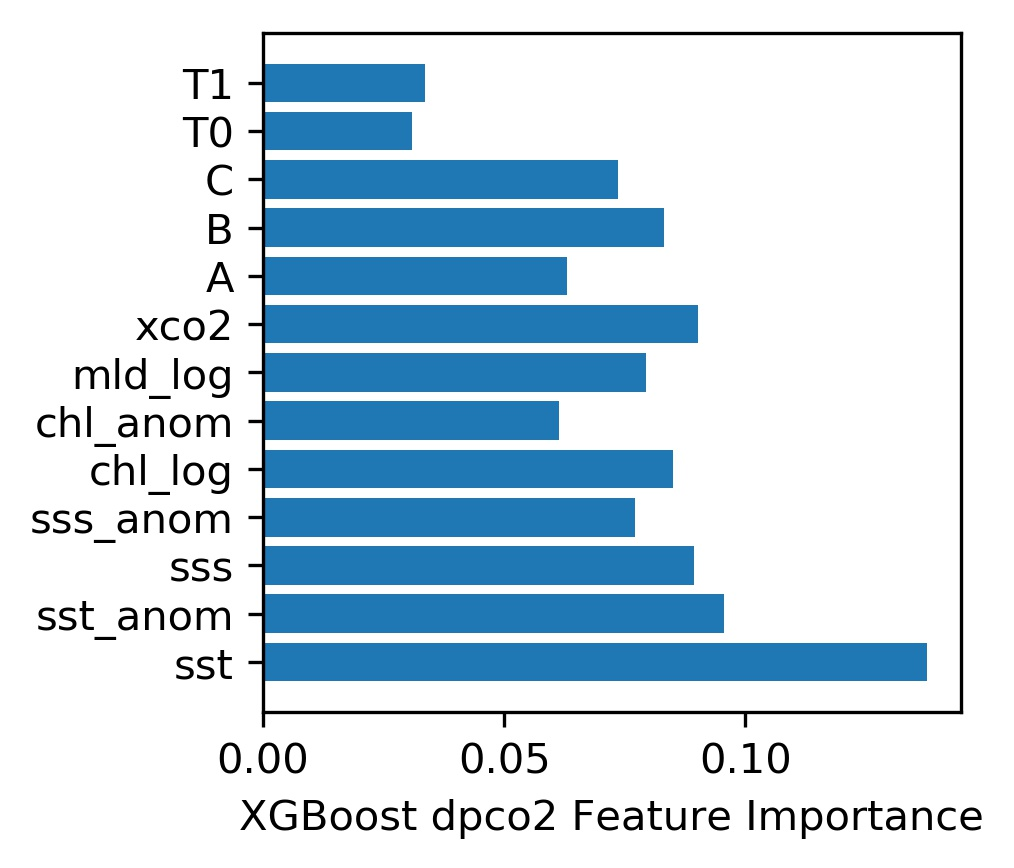

In [12]:
fig = plt.figure(figsize=(3,3))
plt.barh(features_sel, model.feature_importances_)
plt.xlabel("XGBoost dpco2 Feature Importance")

In [26]:
import shap

In [27]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_recon,check_additivity=False)

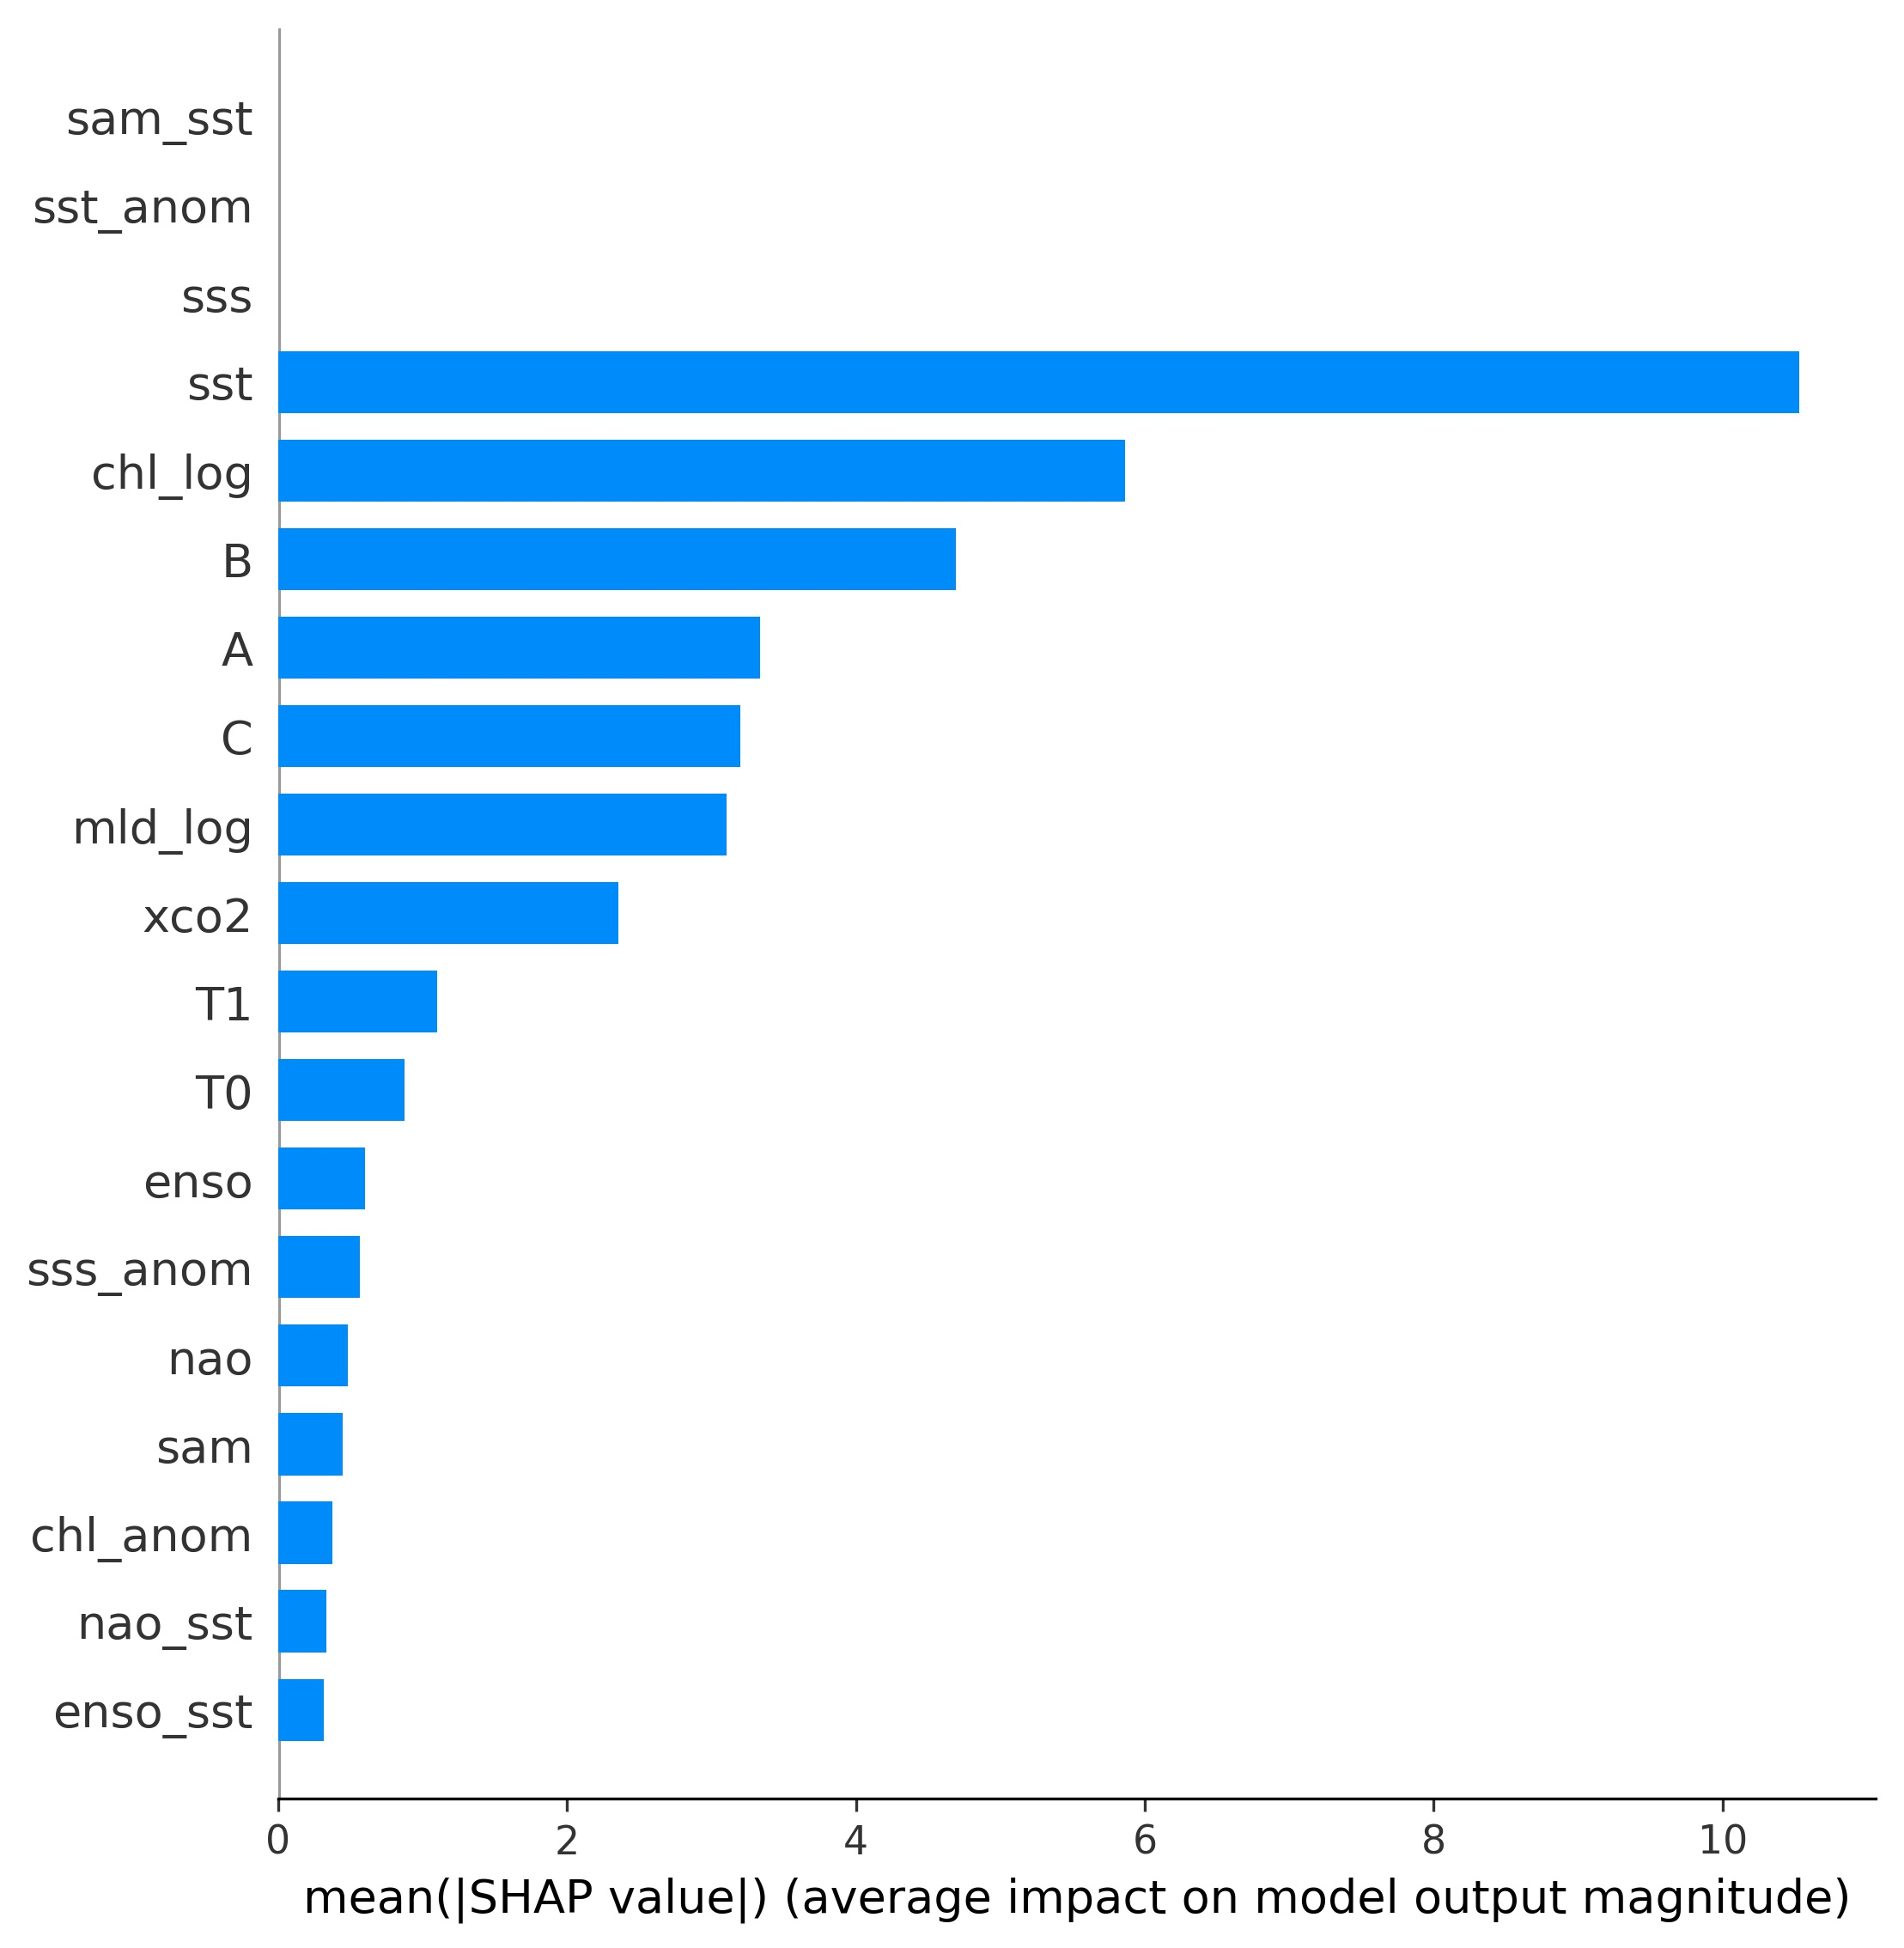

In [29]:
shap.summary_plot(shap_values, X_recon, plot_type="bar",feature_names = features_sel)

In [ ]:
fig = plt.subplots(1,1,figsize=(12,12))
fig=shap.summary_plot(shap_values, X_recon, feature_names = features_sel)

In [33]:
B=df["B"].to_xarray()
C=df["C"].to_xarray()
D=df["D"].to_xarray()

Text(0.5,1,'C')

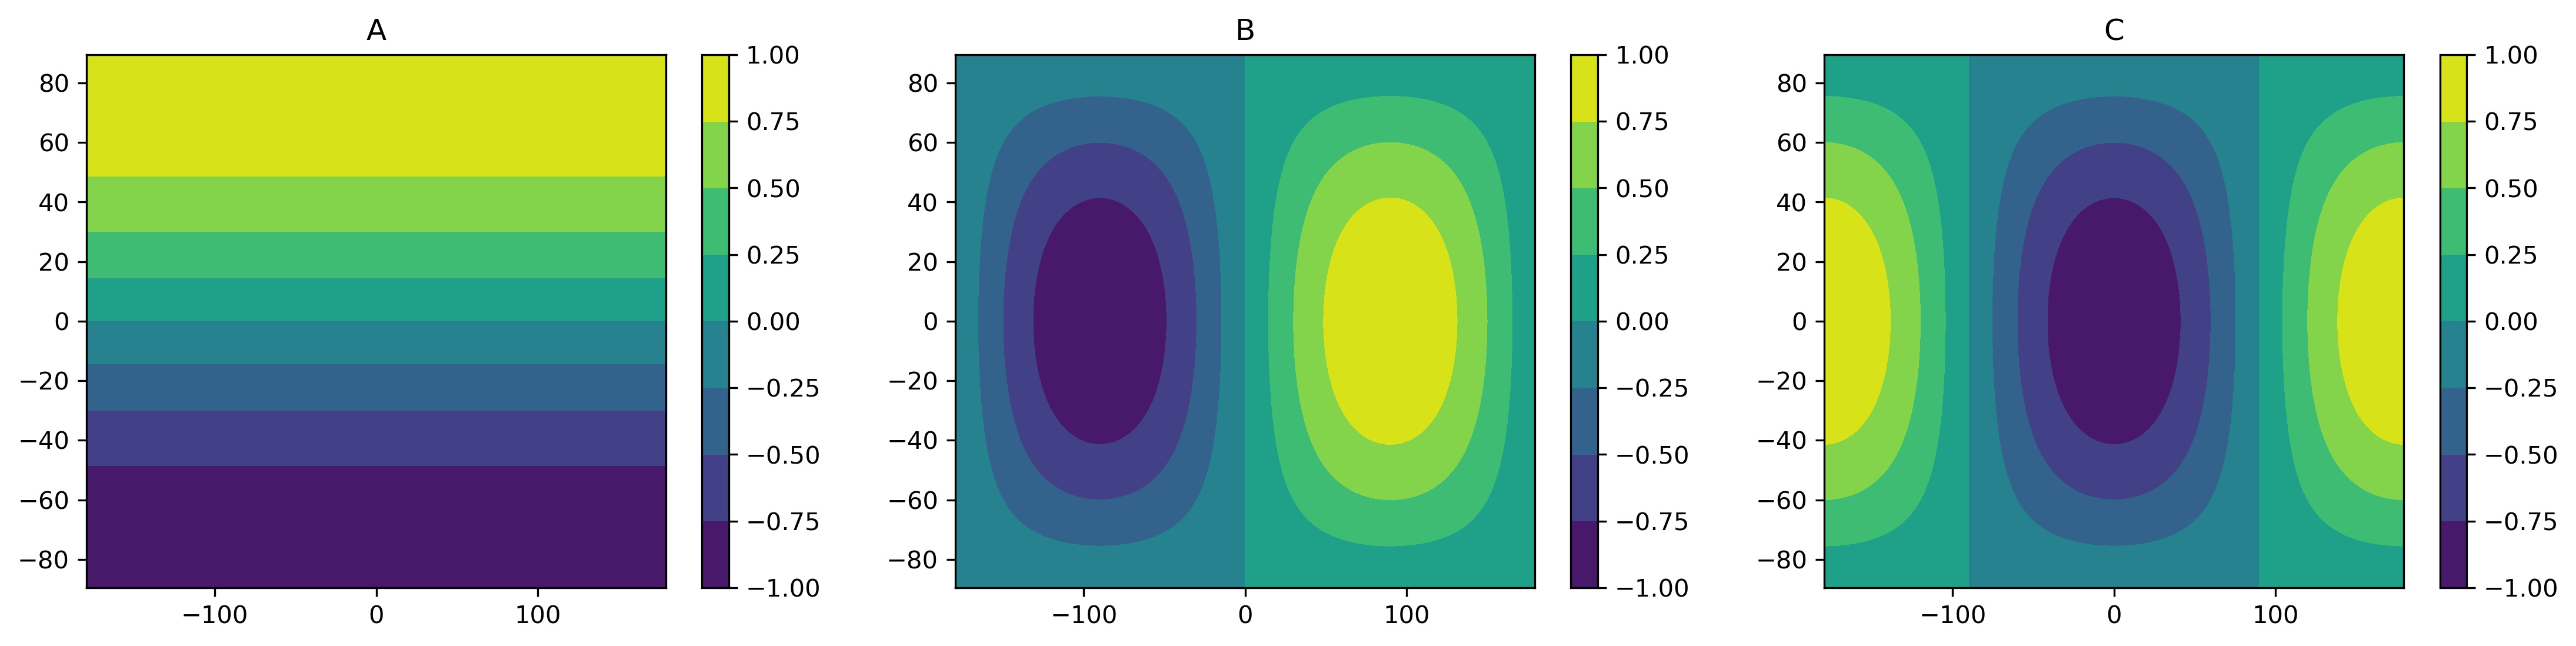

In [43]:
fig,axs= plt.subplots(1,3,figsize=(18,4))
t1=axs[0].contourf(A.xlon,A.ylat,A.mean("time").transpose())
fig.colorbar(t1,ax=axs[0])
axs[0].set_title("A")
t2=axs[1].contourf(B.xlon,B.ylat,B.mean("time").transpose())
fig.colorbar(t2,ax=axs[1])
axs[1].set_title("B")
t3=axs[2].contourf(C.xlon,C.ylat,C.mean("time").transpose())
fig.colorbar(t3,ax=axs[2])
axs[2].set_title("C")

Text(0.5,1,'B+C')

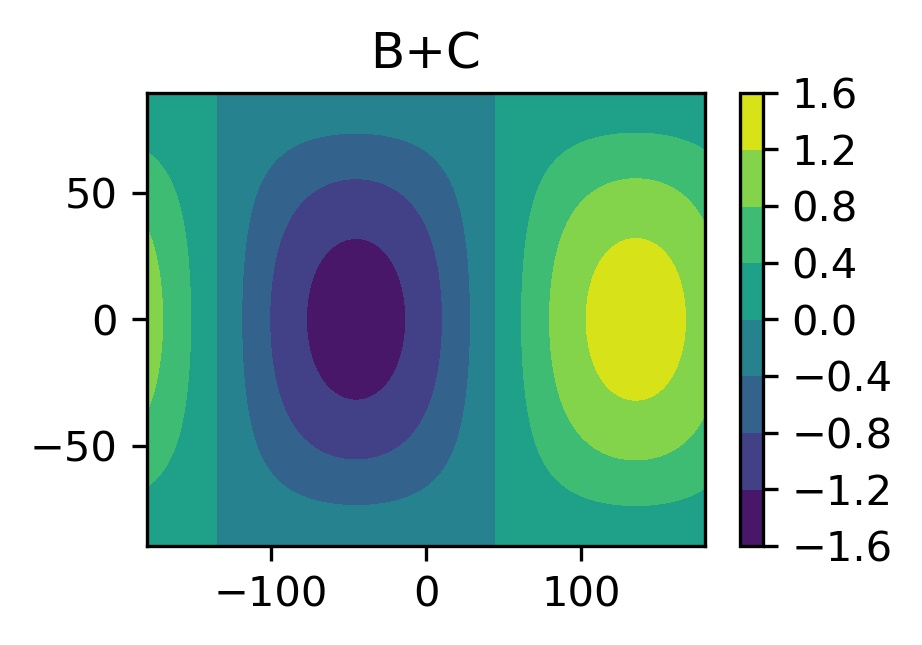

In [49]:
fig = plt.subplots(1,1,figsize=(3,2))
t2=plt.contourf(B.xlon,B.ylat,B.mean("time").transpose()+C.mean("time").transpose())
plt.colorbar()
plt.title("B+C")